In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Cross-validation/gridserch tools
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV


# Model fine-tuning and evaluation
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection



# Pipiline tools
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#Deal with outliers
from sklearn.preprocessing import RobustScaler



import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore sklearn/seaborn deprecation warning 

Precision is a good measure to determine, when the costs of False Positive is high.

In [274]:
df= pd.read_csv('./dataset/users.csv')

df.set_index('id', inplace=True) #set id as df index

# New features 

#ratio_outcome_income
df['ratio_outcome_income']= df['monthly_income']/df['monthly_outcome']

#sqrt  
df['sqrt_income']= df['monthly_income']**(1/2)
df['sqrt_outcome']= df['monthly_outcome']**(1/2)

#log
df['log_income']= df['monthly_income'].map(lambda i: np.log(i))
df['log_outcome']= df['monthly_outcome'].map(lambda i: np.log(i))

In [275]:
# Split target feature

X = df.drop(labels = ["class"],axis = 1)
y = df['class']

#There is not imbalance between class 1 and class 0.
(df['class'].sum())/ (df['class'].count())

0.535

/Users/rene/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


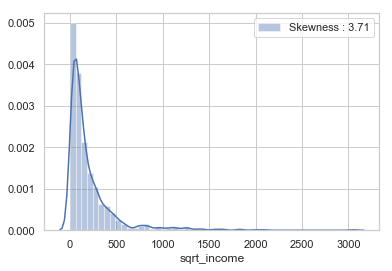

In [276]:
# The features does not follow a normal distrubtion, 
# i.e. wealth is not normally distributed.
# Hence below we first focus on models that do not make such assumption. 
temp=df[(df['monthly_income'] >100000) ]['monthly_income']
temp=df['sqrt_income']

sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")


In [277]:
scaler = StandardScaler()
X_SS = scaler.fit_transform(X) # Helps the most

transformer = RobustScaler().fit(X)
X_RS = transformer.transform(X) # Helps

X_train, X_test, y_train, y_test = train_test_split(X_SS, y, test_size=0.2, random_state=42)

# Modeling Round 1

In [278]:
# Initiate 11 classifier models
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()


models_names=['Random Forest', 'K Nearest Neighbour', 
              'Logistic Regression', 'XGBoost', 
              'Gradient Boosting', 'SVC', 'Extra Trees', 
              'AdaBoost', 'Gaussian Naive Bayes', 
              'Gaussian Process', 'Bagging Classifier']



# Prepare lists and dictionary for future use
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
scores = []
models_dict = dict(zip(models_names, models))

# Sequentially fit and cross validate all models
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring ='precision', cv = 10)
    scores.append(acc.mean())

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Cross validation presicion scores

In [279]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head(11)


,Model,Score
0,Gaussian Naive Bayes,0.733390
1,Logistic Regression,0.669562
2,Gaussian Process,0.665552
3,SVC,0.656779
4,XGBoost,0.654629
5,Gradient Boosting,0.640994
6,AdaBoost,0.640482
7,K Nearest Neighbour,0.630143
8,Bagging Classifier,0.616961
9,Random Forest,0.602904


(0.6, 0.74)

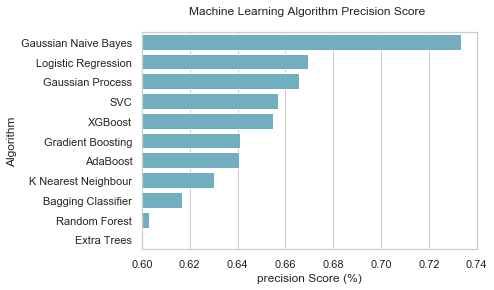

In [280]:
sns.barplot(x='Score', y = 'Model', data = result_df, color = 'c')
plt.title('Precision Score \n')
plt.xlabel('precision Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.60, 0.74)

## Feature importance

In [281]:
# Function for new graph
def importance_plotting(data, x, y, palette, title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data, y_vars=y, x_vars=x, size=5, aspect=1.5)
    ft.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()


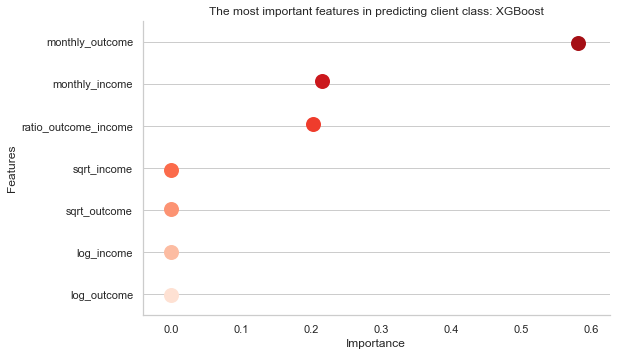

In [282]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting client class: XGBoost']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

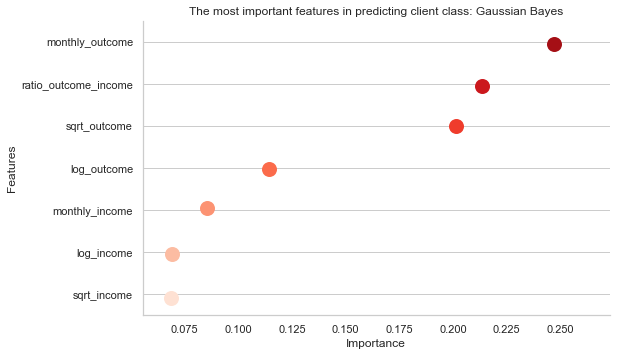

In [283]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':gbc.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting client class: Gaussian Bayes']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

Something is seriesouly wrong here because the feature importance is very different in both cases. Let's next study the learning curves:

In [284]:
kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Learning curves

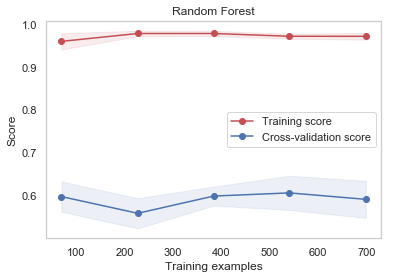

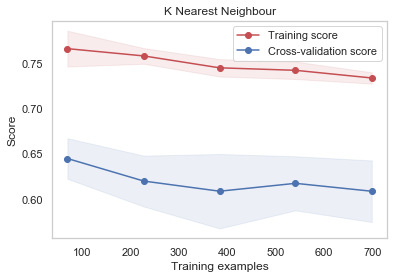

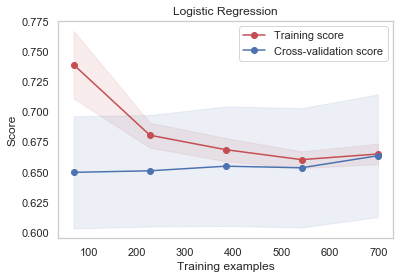

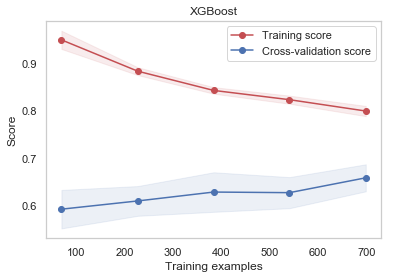

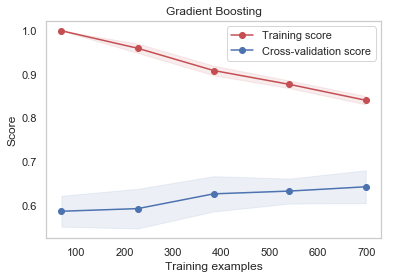

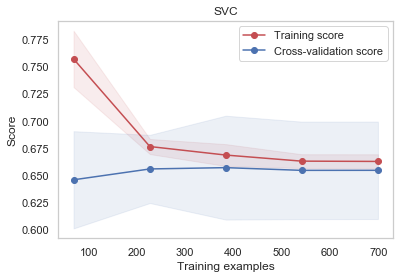

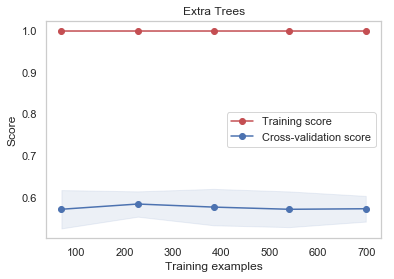

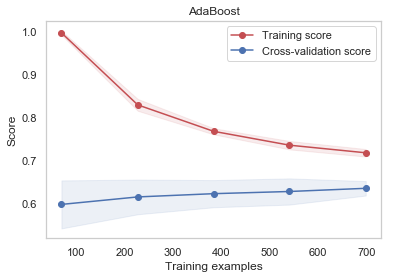

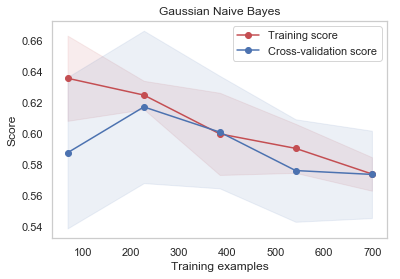

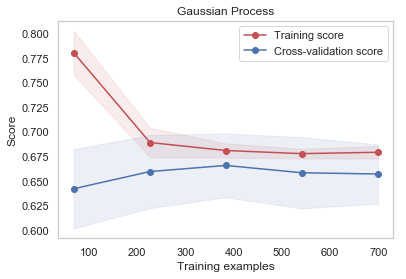

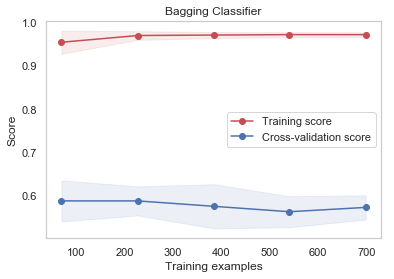

In [285]:
for i in models_names:
    plot_learning_curve(models_dict[i],i,X_train, y_train,cv=kfold)

Learnign curves show that the only models without a Variance problem are:
- Logistic regression
- Support Vector Classifier
- Gaussian process
- AdaBoost

# Modeling Round 2: Feature selection 

In [301]:
# Getting feature importances models that include feature_importances_ method
gbc_imp = pd.DataFrame({'Feature':X.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':X.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':X.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':X.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':X.columns, 'ada importance':ada.feature_importances_})

# Merging results into a single dataframe
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# Calculating average importance per feature
importances['Average'] = importances.mean(axis=1)

# Ranking top to bottom
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

# Display
importances

ValueError: arrays must all be same length

## Model retraining

In [302]:
# Drop redundant features

# Re-build model variables
X_v2=X.drop(['log_income', 'sqrt_income','monthly_income'], axis=1,inplace = False)
scaler = StandardScaler()
X_SS_v2 = scaler.fit_transform(X_v2) # Helps the most

X_train, X_test, y_train, y_test = train_test_split(X_SS_v2, y, test_size=0.2, random_state=42)

scores_v2=[]
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "precision", cv = 10)
    scores_v2.append(acc.mean())

In [303]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Original Score': scores,
    'Score with feature selection': scores_v2})

result_df = results.sort_values(by='Score with feature selection', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection
0,Gaussian Naive Bayes,0.733390,0.693966
1,K Nearest Neighbour,0.630143,0.675580
2,Logistic Regression,0.669562,0.672106
3,Gaussian Process,0.665552,0.661004
4,SVC,0.656779,0.660213
5,XGBoost,0.654629,0.652029
6,AdaBoost,0.640482,0.646452
7,Gradient Boosting,0.640994,0.639649
8,Bagging Classifier,0.616961,0.629137
9,Random Forest,0.602904,0.626472


# Modeling Round 3: (hyper-parameter) tuning

ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

In [333]:
models_dict_v3={}

In [336]:
models_dict_v3={2:2}
models_dict_v3

{2: 2}

In [331]:
# Random Forest

# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]


# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
ran_v3=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision")

# Fitting model and return results
ran_v3.fit(X_train, y_train)
print(ran_v3.best_score_)
print(ran_v3.best_estimator_)


0.6717140724150802
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [324]:

#SVC

# Parameter's to search
Cs = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]

# Setting up parameter grid
hyperparams = {'C': Cs, 'gamma' : gammas}

# Run GridSearch CV
svg_v3=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs= 4)

# Fitting model and return results
svg_v3.fit(X_train, y_train)
print(svg_v3.best_score_)
print(svg_v3.best_estimator_)

0.6699508240297714
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [314]:

#Gradient Boosting Classifier

# Parameter's to search
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 250, 500, 750, 1000]

# Setting up parameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearch CV
gbc_v3=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gbc_v3.best_score_)
print(gbc_v3.best_estimator_)





0.6277311143027171
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
